In [1]:
import google.auth
import google.oauth2
import googleapiclient
import pandas as pd
import openpyxl
import numpy as np
import io
import gspread

from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload,MediaFileUpload
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.errors import HttpError

import pprint
pp = pprint.PrettyPrinter(indent=4)

<span style="font-size: 20px; font-weight:bold">Extract data from Google Drive</span>

In [2]:
# Authenticate and build the Drive API client
SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = 'C:/Users/valer/Projects/test-americor-8e8b3f1bd083.json'
# creds = None
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

drive_service = build('drive', 'v3', credentials=credentials)
sheets_service = build('sheets', 'v4', credentials=credentials)

In [3]:
results = drive_service.files().list(pageSize=10,
                               fields="nextPageToken, files(id, name, mimeType)").execute()
pp.pprint(results)

{   'files': [   {   'id': '1u5vCLZlnNS1JRI5dV57KFTA38YOKJAoCncoMv3c-F9A',
                     'mimeType': 'application/vnd.google-apps.spreadsheet',
                     'name': 'Test Americor Exercise 4'},
                 {   'id': '164qtlka8K5wb0Vb5-bgEw2mAcyoxuoLl81xYDZUoLnw',
                     'mimeType': 'application/vnd.google-apps.spreadsheet',
                     'name': 'Test Americor Exercise 4'},
                 {   'id': '1bYuzcTK45QrH3IR_IfrwmdAs89zEKuut',
                     'mimeType': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet',
                     'name': 'department.xlsx'},
                 {   'id': '1fQNzHY4t3eta0-eFlKl-VTpzTSESksV5',
                     'mimeType': 'application/vnd.google-apps.folder',
                     'name': 'My folder for test'},
                 {   'id': '1ZunIGOYpVs5WmH4ECuW0B-dPLKvbL_8z',
                     'mimeType': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet',
              

In [4]:
# Define the folder ID and file names
folder_id = '1fQNzHY4t3eta0-eFlKl-VTpzTSESksV5'
# folder_id = '1lWzo6eZ2N_w27YZ43MIcQbGREv3L-21j'
file_names = ['crm_dictionary.xlsx', 'customer_action.xlsx', 'customer_creditor_action.xlsx', 'department.xlsx', 'team.xlsx', 'user_team.xlsx', 'user_team_change.xlsx']

In [5]:
# Loop through the file names and read each file
dfs = {} 

for file_name in file_names:
    # Find the file ID
    query = "name='{}' and parents='{}' and mimeType='application/vnd.openxmlformats-officedocument.spreadsheetml.sheet'".format(file_name, folder_id)
    results = drive_service.files().list(q=query, fields="files(id)").execute()
    items = results.get('files', [])
    if not items:
        print('File not found: {}'.format(file_name))
        continue
    file_id = items[0]['id']
    
    try:
        # Download the file contents
        file = drive_service.files().get_media(fileId=file_id)
        file_content = file.execute()
        file_bytes = io.BytesIO(file_content)
        
        # Check the type of the file_bytes object
        if not isinstance(file_bytes.getvalue(), bytes):
            raise ValueError("Invalid file contents")
        
        # Read the file contents into a Pandas dataframe
        df = pd.read_excel(file_bytes, sheet_name=0, header=0)
        
        # Conduct exploratory data analysis
        # print('----------------------------------------')
        # print('Exploratory data analysis for {}:\n'.format(file_name))
        # print('Dataframe shape:', df.shape)
        # print('\nDataframe info:')
        # print(df.info())
        # print('\nDescriptive statistics:')
        # print(df.describe())
        # print('\nMissing values:')
        # print(df.isnull().sum())
        # print('\nDuplicate rows:')
        # print(df.duplicated().sum())
        # df.head()
        # print('----------------------------------------')
        
        # Add the dataframe to the dictionary with the file name as key
        df_name = 'df_' + file_name.split('.')[0]
        dfs[df_name] = df
        
        print('Dataframe name:', df_name)
        print('Dataframe columns:', list(df.columns))
        
    except Exception as e:
        print('Error while processing {}: {}'.format(file_name, str(e)))


Dataframe name: df_crm_dictionary
Dataframe columns: ['id', 'crm_object_name', 'crm_object_attribute', 'crm_object_id', 'crm_object_description']
Dataframe name: df_customer_action
Dataframe columns: ['log_id', 'ins_ts', 'user_id', 'customer_id', 'old_value', 'new_value']
Dataframe name: df_customer_creditor_action
Dataframe columns: ['log_id', 'ins_ts', 'user_id', 'customer_creditor_id', 'old_value', 'new_value']
Dataframe name: df_department
Dataframe columns: ['id', 'title']
Dataframe name: df_team
Dataframe columns: ['id', 'name', 'department_id', 'updated_at']
Dataframe name: df_user_team
Dataframe columns: ['user_id', 'team_id', 'updated_at', 'id']
Dataframe name: df_user_team_change
Dataframe columns: ['id', 'ins_ts', 'user_id', 'attribute', 'old_value', 'new_value']


<span style="font-size: 20px; font-weight:bold">Exercise 1</span>


In [6]:
print(dfs['df_customer_action'].head())

       log_id              ins_ts  user_id  customer_id  old_value  new_value
0  1217408899 2020-11-01 00:07:38     5910      1102636       15.0         41
1  1217413011 2020-11-01 00:16:29     5200      2312093       16.0         13
2  1217415671 2020-11-01 00:21:13     6361      2311203       16.0         13
3  1217433239 2020-11-01 01:22:01     5200      2312329        NaN          0
4  1217433377 2020-11-01 01:22:43     5200      2312329        0.0         16


In [7]:
# Find the top 3 most frequent new values in the customer_action table
top_3_values = dfs['df_customer_action']['new_value'].value_counts().nlargest(3).index.tolist()
print(top_3_values)

[16, 3, 0]


In [8]:
# Filter the customer table to only include the top 3 values
df_customer_action_filtered = dfs['df_customer_action'][dfs['df_customer_action']['new_value'].isin(top_3_values)]

In [9]:
print(df_customer_action_filtered.head())

       log_id              ins_ts  user_id  customer_id  old_value  new_value
3  1217433239 2020-11-01 01:22:01     5200      2312329        NaN          0
4  1217433377 2020-11-01 01:22:43     5200      2312329        0.0         16
5  1217435949 2020-11-01 01:36:13     5200      2312329       16.0          3
6  1217453993 2020-11-01 02:58:43     5200      2263435        0.0         16
7  1217456409 2020-11-01 03:06:53     5200      2312515        0.0         16


In [10]:
# Group the data by user_id and month, and count the number of actions
df_actions_by_user_month = (df_customer_action_filtered.groupby(['user_id', pd.Grouper(key='ins_ts', freq='M')])
                            .size()
                            .reset_index(name='Total_Action_Count'))
print(df_actions_by_user_month)
print('Dataframe columns:', list(df_actions_by_user_month.columns))

     user_id     ins_ts  Total_Action_Count
0          1 2020-12-31                   1
1       4003 2020-12-31                   1
2       4028 2020-11-30                   2
3       4061 2020-11-30                  27
4       4061 2020-12-31                  39
..       ...        ...                 ...
401     6814 2020-12-31                  95
402     6817 2020-12-31                  69
403     6820 2020-12-31                  30
404     6826 2020-12-31                  72
405     6829 2020-12-31                  43

[406 rows x 3 columns]
Dataframe columns: ['user_id', 'ins_ts', 'Total_Action_Count']


In [11]:
print('Dataframe df_user_team columns:', list(dfs['df_user_team'].columns))
print('Dataframe df_actions_by_user_month columns:', list(df_actions_by_user_month.columns))

Dataframe df_user_team columns: ['user_id', 'team_id', 'updated_at', 'id']
Dataframe df_actions_by_user_month columns: ['user_id', 'ins_ts', 'Total_Action_Count']


In [12]:
# Join the user and team data to get the team information
df_user_team = pd.merge(dfs['df_user_team'], dfs['df_team'], left_on='team_id', right_on='id')
# Join tables to get team and department information
df_user_team_team = pd.merge(dfs['df_user_team'], dfs['df_team'], how='left', left_on='team_id', right_on='id')
df_user_team_department = pd.merge(df_user_team_team, dfs['df_department'], how='left', left_on='department_id', right_on='id')
df_user_team_department.drop(['id_x', 'id_y', 'updated_at_x', 'updated_at_y'], axis=1, inplace=True)
print('Dataframe df_user_team_department columns:', list(df_user_team_department.columns))
print(df_user_team_department)

Dataframe df_user_team_department columns: ['user_id', 'team_id', 'name', 'department_id', 'id', 'title']
     user_id  team_id                    name  department_id   id  \
0       4694       11         Team Sales- Joe            1.0  1.0   
1       4795       11         Team Sales- Joe            1.0  1.0   
2       4628       11         Team Sales- Joe            1.0  1.0   
3       4863       11         Team Sales- Joe            1.0  1.0   
4       4662       15             Team Renata            3.0  3.0   
..       ...      ...                     ...            ...  ...   
900     7405       46  Team Carren (Trainees)            2.0  2.0   
901     6146       51            CS Team - LC            3.0  3.0   
902     6787       53            CS Team - CC            3.0  3.0   
903     7277        8            Team Jocelyn            2.0  2.0   
904     6233       11         Team Sales- Joe            1.0  1.0   

                title  
0               Sales  
1               S

In [13]:
df_user_team_department = df_user_team_department.drop(['id'], axis=1) # remove unnecessary columns
df_user_team_department = df_user_team_department.rename(columns={'name': 'team_name', 'title': 'department_name'}) # rename the 'name' column to 'team_name'
print('Dataframe df_user_team_department columns:', list(df_user_team_department.columns))
print(df_user_team_department)

Dataframe df_user_team_department columns: ['user_id', 'team_id', 'team_name', 'department_id', 'department_name']
     user_id  team_id               team_name  department_id   department_name
0       4694       11         Team Sales- Joe            1.0             Sales
1       4795       11         Team Sales- Joe            1.0             Sales
2       4628       11         Team Sales- Joe            1.0             Sales
3       4863       11         Team Sales- Joe            1.0             Sales
4       4662       15             Team Renata            3.0  Customer Service
..       ...      ...                     ...            ...               ...
900     7405       46  Team Carren (Trainees)            2.0      Negotiations
901     6146       51            CS Team - LC            3.0  Customer Service
902     6787       53            CS Team - CC            3.0  Customer Service
903     7277        8            Team Jocelyn            2.0      Negotiations
904     6233    

In [14]:
# Join the user team department table with the actions by user and month table
df_actions_merged = pd.merge(df_actions_by_user_month, df_user_team_department, how='left', left_on='user_id', right_on='user_id')


In [15]:
print('Dataframe df_actions_merged columns:', list(df_actions_merged.columns))
print(df_actions_merged)

Dataframe df_actions_merged columns: ['user_id', 'ins_ts', 'Total_Action_Count', 'team_id', 'team_name', 'department_id', 'department_name']
     user_id     ins_ts  Total_Action_Count  team_id            team_name  \
0          1 2020-12-31                   1      NaN                  NaN   
1       4003 2020-12-31                   1     33.0                The U   
2       4028 2020-11-30                   2      NaN                  NaN   
3       4061 2020-11-30                  27      3.0  Team Sales - Jordan   
4       4061 2020-12-31                  39      3.0  Team Sales - Jordan   
..       ...        ...                 ...      ...                  ...   
401     6814 2020-12-31                  95     41.0          The U Boise   
402     6817 2020-12-31                  69     41.0          The U Boise   
403     6820 2020-12-31                  30     50.0       Boise Warriors   
404     6826 2020-12-31                  72     50.0       Boise Warriors   
405     6829

In [16]:
# Group the data by team, department, user, and month, and calculate the total action count for each user and month
df_actions_merged = (df_actions_merged.groupby(['team_name', 'department_name', 'user_id', pd.Grouper(key='ins_ts', freq='M')])
                                            .agg({'Total_Action_Count': 'sum'})
                                            .reset_index())

print(df_actions_merged)
print('Dataframe df_actions_merged columns:', list(df_actions_merged.columns))

          team_name department_name  user_id     ins_ts  Total_Action_Count
0    Boise Warriors           Sales     4481 2020-11-30                 170
1    Boise Warriors           Sales     4481 2020-12-31                 137
2    Boise Warriors           Sales     4679 2020-11-30                  52
3    Boise Warriors           Sales     5033 2020-11-30                 144
4    Boise Warriors           Sales     5033 2020-12-31                  74
..              ...             ...      ...        ...                 ...
372     The U Boise           Sales     6346 2020-11-30                  90
373     The U Boise           Sales     6352 2020-11-30                  58
374     The U Boise           Sales     6814 2020-12-31                  95
375     The U Boise           Sales     6817 2020-12-31                  69
376     The U Boise           Sales     6829 2020-12-31                  43

[377 rows x 5 columns]
Dataframe df_actions_merged columns: ['team_name', 'department_n

In [17]:
# Calculate the month-over-month percentage change for each user
df_actions_merged['MoM%'] = df_actions_merged.groupby(['team_name', 'department_name', 'user_id'])['Total_Action_Count'].pct_change().fillna(0).round(2)

print('Dataframe df_actions_merged columns:', list(df_actions_merged.columns))
print(df_actions_merged)

Dataframe df_actions_merged columns: ['team_name', 'department_name', 'user_id', 'ins_ts', 'Total_Action_Count', 'MoM%']
          team_name department_name  user_id     ins_ts  Total_Action_Count  \
0    Boise Warriors           Sales     4481 2020-11-30                 170   
1    Boise Warriors           Sales     4481 2020-12-31                 137   
2    Boise Warriors           Sales     4679 2020-11-30                  52   
3    Boise Warriors           Sales     5033 2020-11-30                 144   
4    Boise Warriors           Sales     5033 2020-12-31                  74   
..              ...             ...      ...        ...                 ...   
372     The U Boise           Sales     6346 2020-11-30                  90   
373     The U Boise           Sales     6352 2020-11-30                  58   
374     The U Boise           Sales     6814 2020-12-31                  95   
375     The U Boise           Sales     6817 2020-12-31                  69   
376     Th

In [18]:
# Use df_actions_merged as the source table
df_pivot = pd.pivot_table(df_actions_merged, values='Total_Action_Count', index=['user_id', 'team_name', 'department_name'],
columns=['ins_ts'], aggfunc=sum, fill_value=0)

# Rename columns to add the '_Total_Action_Count' suffix
df_pivot.columns = [col.strftime('%b %Y') + '_Action_Count' for col in df_pivot.columns]

# Calculate the MoM% for each month
df_pivot['MoM%'] = ((df_pivot.iloc[:, 1] - df_pivot.iloc[:, 0]) / df_pivot.iloc[:, 0]).round(2)

df_pivot['MoM%'] = df_pivot['MoM%'].replace([np.inf, -np.inf], np.nan).fillna("N/A")

# Sort the rows by user_id
df_pivot.sort_values(by='user_id', inplace=True)

print(df_pivot)

                                             Nov 2020_Action_Count  \
user_id team_name           department_name                          
4003    The U               Sales                                0   
4061    Team Sales - Jordan Sales                               27   
4270    Team Sales - Jordan Sales                              203   
4290    Team Sales - Jordan Sales                              182   
4356    Team Sales - Jordan Sales                              298   
...                                                            ...   
6814    The U Boise         Sales                                0   
6817    The U Boise         Sales                                0   
6820    Boise Warriors      Sales                                0   
6826    Boise Warriors      Sales                                0   
6829    The U Boise         Sales                                0   

                                             Dec 2020_Action_Count  MoM%  
user_id team_n

In [19]:
df_pivot.reset_index(inplace=True)
df_pivot.to_excel(r'C:\Users\valer\Projects\exercise_1.xlsx', index=False)

<span style="font-size: 20px; font-weight:bold">Exercise 2</span>

In [20]:
# Merge df_customer_action with df_crm_dictionary on condition "crm_object_name"=customer, crm_object_id

df_customer_action = pd.merge(dfs['df_customer_action'], dfs['df_crm_dictionary'][dfs['df_crm_dictionary']['crm_object_name']=='customer'][['crm_object_id', 'crm_object_description']], how='left', left_on='old_value', right_on='crm_object_id').drop(columns=['crm_object_id'])
df_customer_action = df_customer_action.rename(columns={'crm_object_description': 'old_value_description'})

df_customer_action = pd.merge(df_customer_action, dfs['df_crm_dictionary'][dfs['df_crm_dictionary']['crm_object_name']=='customer'][['crm_object_id', 'crm_object_description']], how='left', left_on='new_value', right_on='crm_object_id').drop(columns=['crm_object_id'])
df_customer_action = df_customer_action.rename(columns={'crm_object_description': 'new_value_description'})

print(df_customer_action.head())

       log_id              ins_ts  user_id  customer_id  old_value  new_value  \
0  1217408899 2020-11-01 00:07:38     5910      1102636       15.0         41   
1  1217413011 2020-11-01 00:16:29     5200      2312093       16.0         13   
2  1217415671 2020-11-01 00:21:13     6361      2311203       16.0         13   
3  1217433239 2020-11-01 01:22:01     5200      2312329        NaN          0   
4  1217433377 2020-11-01 01:22:43     5200      2312329        0.0         16   

  old_value_description new_value_description  
0         Overdue Pitch       follow up pitch  
1        Ready To Pitch             Docs Sent  
2        Ready To Pitch             Docs Sent  
3                   NaN              Lead New  
4              Lead New        Ready To Pitch  


In [21]:
# Merge df_customer_creditor_action with df_crm_dictionary on condition "crm_object_name"=customer_creditor, crm_object_id

df_customer_creditor_action = pd.merge(dfs['df_customer_creditor_action'], dfs['df_crm_dictionary'][dfs['df_crm_dictionary']['crm_object_name']=='customer_creditor'][['crm_object_id', 'crm_object_description']], how='left', left_on='old_value', right_on='crm_object_id').drop(columns=['crm_object_id'])
df_customer_creditor_action = df_customer_creditor_action.rename(columns={'crm_object_description': 'old_value_description'})

df_customer_creditor_action = pd.merge(df_customer_creditor_action, dfs['df_crm_dictionary'][dfs['df_crm_dictionary']['crm_object_name']=='customer_creditor'][['crm_object_id', 'crm_object_description']], how='left', left_on='new_value', right_on='crm_object_id').drop(columns=['crm_object_id'])
df_customer_creditor_action = df_customer_creditor_action.rename(columns={'crm_object_description': 'new_value_description'})

print(df_customer_creditor_action.head())

       log_id              ins_ts  user_id  customer_creditor_id  old_value  \
0  1217434655 2020-11-01 01:34:09     5200              17841703        NaN   
1  1217434711 2020-11-01 01:34:09     5200              17841705        NaN   
2  1217434773 2020-11-01 01:34:09     5200              17841707        NaN   
3  1217434835 2020-11-01 01:34:09     5200              17841709        NaN   
4  1217434891 2020-11-01 01:34:09     5200              17841711        NaN   

   new_value old_value_description new_value_description  
0        0.0                   NaN           Not Started  
1        0.0                   NaN           Not Started  
2        0.0                   NaN           Not Started  
3        0.0                   NaN           Not Started  
4        0.0                   NaN           Not Started  


In [22]:
# Merge df_user_team_department with df_customer_action and df_customer_creditor_action on user_id
df_customer_action = df_customer_action.merge(df_user_team_department, on='user_id')
df_customer_creditor_action = df_customer_creditor_action.merge(df_user_team_department, on='user_id')

print('Dataframe df_customer_action columns:', list(df_customer_action.columns))
print('Dataframe df_customer_creditor_action columns:', list(df_customer_creditor_action.columns))

Dataframe df_customer_action columns: ['log_id', 'ins_ts', 'user_id', 'customer_id', 'old_value', 'new_value', 'old_value_description', 'new_value_description', 'team_id', 'team_name', 'department_id', 'department_name']
Dataframe df_customer_creditor_action columns: ['log_id', 'ins_ts', 'user_id', 'customer_creditor_id', 'old_value', 'new_value', 'old_value_description', 'new_value_description', 'team_id', 'team_name', 'department_id', 'department_name']


In [24]:
df_customer_action = df_customer_action.loc[:, ['log_id', 'ins_ts', 'user_id', 'old_value_description', 'new_value_description', 'department_name']]
df_customer_creditor_action = df_customer_creditor_action.loc[:, ['log_id', 'ins_ts', 'user_id', 'old_value_description', 'new_value_description', 'department_name']]


In [25]:
# Add "month"
df_customer_action['month'] = pd.to_datetime(df_customer_action['ins_ts']).dt.to_period('M')
df_customer_creditor_action['month'] = pd.to_datetime(df_customer_creditor_action['ins_ts']).dt.to_period('M')

In [26]:
# Grouping data by department, month
grouped_action = df_customer_action.groupby(['department_name', 'month', 'old_value_description', 'new_value_description']).size().reset_index(name='count')
grouped_creditor_action = df_customer_creditor_action.groupby(['department_name', 'month', 'old_value_description', 'new_value_description']).size().reset_index(name='count')

In [27]:
# Calculate top 3 changes for each department and month
top3_action = grouped_action.groupby(['department_name', 'month']).apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)
top3_creditor_action = grouped_creditor_action.groupby(['department_name', 'month']).apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

In [28]:
# Make a copy of the dataframes
top3_action_copy = top3_action.copy()
top3_creditor_action_copy = top3_creditor_action.copy()

# Sort the copy by department and month in ascending order
top3_action_copy = top3_action_copy.sort_values(['department_name', 'month'])
top3_creditor_action_copy = top3_creditor_action_copy.sort_values(['department_name', 'month'])


In [29]:
# Calculate MoM% for each department and month using pct_change()
top3_action_copy['MoM%'] = top3_action_copy.groupby('department_name')['count'].pct_change().round(2)
top3_creditor_action_copy['MoM%'] = top3_creditor_action_copy.groupby('department_name')['count'].pct_change().round(2)


In [30]:
# Print the result
print("Top 3 changes for customer actions:")
print(top3_action_copy)
print("\nTop 3 changes for creditor actions:")
print(top3_creditor_action_copy)

Top 3 changes for customer actions:
             department_name    month old_value_description  \
0           Customer Service  2020-11      Client Relations   
1           Customer Service  2020-11                Active   
2           Customer Service  2020-11      Client Relations   
3           Customer Service  2020-12      Client Relations   
4           Customer Service  2020-12                Active   
5           Customer Service  2020-12      Nsf Unresponsive   
6                Enrollments  2020-11              Deal New   
7                Enrollments  2020-11                   Nsf   
8                Enrollments  2020-11      Nsf Unresponsive   
9                Enrollments  2020-12              Deal New   
10               Enrollments  2020-12                   Nsf   
11               Enrollments  2020-12      Nsf Unresponsive   
12              Negotiations  2020-11                   Nsf   
13              Negotiations  2020-11      Nsf Unresponsive   
14              Neg

In [31]:
# Save the dataframes to separate sheets in the Excel file
writer = pd.ExcelWriter('C:/Users/valer/Projects/exercise_2.xlsx', engine='xlsxwriter')

with pd.ExcelWriter('C:/Users/valer/Projects/exercise_2.xlsx') as writer:
    top3_action_copy.to_excel(writer, sheet_name='top3_customer_action', index=False)
    top3_creditor_action_copy.to_excel(writer, sheet_name='top3_customer_creditor_action', index=False)

writer.save()

C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


<span style="font-size: 20px; font-weight:bold">Exercise 3</span>

In [32]:
# filter customer_action table to get actions of staff member 4462 before 12/14/2020
df_staff_actions = dfs['df_customer_action'][(dfs['df_customer_action'].user_id == 4462) & (dfs['df_customer_action'].ins_ts < '2020-12-14')]

print(df_staff_actions)

           log_id              ins_ts  user_id  customer_id  old_value  \
2160   1219714869 2020-11-02 19:56:47     4462      2318629        0.0   
2195   1219770091 2020-11-02 20:08:11     4462      1258951       18.0   
2757   1220360995 2020-11-02 21:59:17     4462      2310763       22.0   
2768   1220371277 2020-11-02 22:01:07     4462      1446667       41.0   
2826   1220408443 2020-11-02 22:10:04     4462      2319817       22.0   
...           ...                 ...      ...          ...        ...   
90163  1351051525 2020-12-11 02:01:10     4462      2483188       16.0   
90477  1351619767 2020-12-11 15:47:56     4462      2462731       16.0   
90482  1351621540 2020-12-11 15:48:23     4462      2498425       16.0   
90495  1351633807 2020-12-11 15:52:07     4462      2501575       16.0   
90984  1352376364 2020-12-11 17:30:11     4462      2485729       18.0   

       new_value  
2160          16  
2195          16  
2757          16  
2768           3  
2826          16

In [33]:
# Group by the new values and count the occurrences
top_statuses = df_staff_actions.groupby('new_value').size().reset_index(name='count')
print(top_statuses)

   new_value  count
0          0     54
1          3    144
2          4      2
3         13     34
4         16    252
5         17      1
6         41    130


In [34]:
# Sort by count and select the top 3 most frequent statuses
top_statuses = top_statuses.sort_values('count', ascending=False).head(3)
print(top_statuses)

   new_value  count
4         16    252
1          3    144
6         41    130


In [35]:
# Replace new_value with status title crm_object_description
merged_df = top_statuses.merge(dfs['df_crm_dictionary'][dfs['df_crm_dictionary']['crm_object_name'] == 'customer'], left_on='new_value', right_on='crm_object_id')
top_statuses['new_value'] = merged_df['crm_object_description'].values
print(top_statuses)

         new_value  count
4   Ready To Pitch    252
1         Nurtured    144
6  follow up pitch    130


In [36]:
top_statuses.reset_index(inplace=True)
top_statuses.to_excel(r'C:\Users\valer\Projects\exercise_3.xlsx', index=False)

<span style="font-size: 20px; font-weight:bold">Exercise 4</span>

In [37]:
# Create a new column date in DataFrame df_user_team that will contain only the date from the updated_at column.
dfs['df_user_team']['date'] = pd.to_datetime(dfs['df_user_team']['updated_at']).dt.date

In [38]:
# Filter the rows in DataFrame df_user_team to keep only the team changes made before 12/14/2019 or empty
user_team_before_dec14 = dfs['df_user_team'][(dfs['df_user_team']['date'] <= pd.to_datetime('2019-12-14').date()) | (dfs['df_user_team']['updated_at'].isnull())]
print(user_team_before_dec14)

     user_id  team_id          updated_at   id        date
0       4694       11                 NaT    1         NaN
1       4795       11                 NaT    2         NaN
2       4628       11                 NaT    3         NaN
3       4863       11                 NaT    4         NaN
4       4662       15                 NaT    5         NaN
..       ...      ...                 ...  ...         ...
239     5753       11 2019-12-12 18:18:13  323  2019-12-12
240     5765        3 2019-12-12 18:21:31  325  2019-12-12
241     5735        3 2019-12-12 18:21:31  326  2019-12-12
242     5758       47 2019-12-12 18:22:52  327  2019-12-12
243     5741       47 2019-12-12 18:22:52  328  2019-12-12

[244 rows x 5 columns]


In [46]:
# Find sales teams (department Sales)
sales_teams = dfs['df_team'].loc[dfs['df_team']['department_id'] == 1]
print(sales_teams)

    id                        name  department_id          updated_at
0    2                       The U            1.0 2020-02-13 19:12:06
1    3         Team Sales - Jordan            1.0 2020-12-02 15:19:16
4   11             Team Sales- Joe            1.0 2020-10-16 22:06:28
10  19     Team Consistency - Omar            1.0 2021-03-10 19:57:10
15  24                   Team Andy            1.0 2019-10-09 16:46:25
16  26                   Team Mike            1.0 2019-03-01 19:10:36
17  27                  Team Katie            1.0 2019-04-09 20:36:04
18  28     Team One Percent - Ford            1.0 2020-10-16 22:30:07
19  33                       The U            1.0 2021-05-12 00:07:58
22  41                 The U Boise            1.0 2020-12-05 00:12:33
26  45              Openers Mexico            1.0 2019-09-05 19:26:45
28  47  Team Closers Club - Joseph            1.0 2020-10-16 22:32:21
30  50              Boise Warriors            1.0 2020-12-05 00:13:13
45  73           Tea

In [44]:
# Get the user to sales team mapping
sales_team_members = pd.merge(user_team_before_dec14, sales_teams, left_on='team_id', right_on='id')
print(sales_team_members)

     user_id  team_id        updated_at_x  id_x        date  id_y  \
0       4694       11                 NaT     1         NaT    11   
1       4795       11                 NaT     2         NaT    11   
2       4628       11                 NaT     3         NaT    11   
3       4863       11                 NaT     4         NaT    11   
4       5117       11                 NaT    31         NaT    11   
..       ...      ...                 ...   ...         ...   ...   
205     5651       24 2019-10-14 17:16:56   221  2019-10-14    24   
206     5714       24 2019-11-12 17:24:02   264  2019-11-12    24   
207     5709       24 2019-11-12 17:24:44   265  2019-11-12    24   
208     5779       24 2019-12-09 17:28:00   298  2019-12-09    24   
209     5777       24 2019-12-09 17:28:11   299  2019-12-09    24   

                name  department_id        updated_at_y  
0    Team Sales- Joe            1.0 2020-10-16 22:06:28  
1    Team Sales- Joe            1.0 2020-10-16 22:06:28

In [47]:
# Calculate headcount of each sales team by grouping on name column and counting unique user_id values

headcount = sales_team_members.groupby('name')['user_id'].nunique()
headcount = headcount.sort_values(ascending=False).reset_index().rename(columns={'name': 'Sales Team', 'user_id': 'Headcount'})
print(headcount)

                    Sales Team  Headcount
0               Openers Mexico         27
1      Team Consistency - Omar         25
2      Team One Percent - Ford         23
3          Team Sales - Jordan         23
4              Team Sales- Joe         23
5   Team Closers Club - Joseph         21
6                    Team Mike         21
7                        The U         12
8                   Team Katie         11
9                    Team Andy          9
10              Boise Warriors          8
11                 The U Boise          7


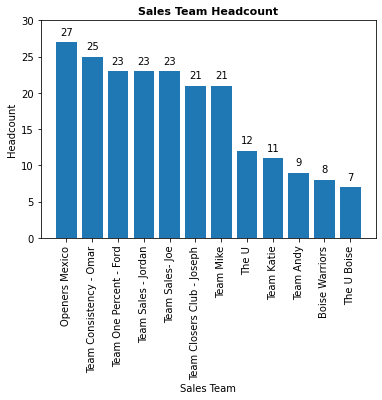

In [48]:
import matplotlib.pyplot as plt

# create a bar chart
plt.bar(headcount['Sales Team'], headcount['Headcount'])

# set the title and labels
plt.title('Sales Team Headcount', fontdict={'fontsize': 11, 'fontweight': 'bold'})
plt.xlabel('Sales Team')
plt.ylabel('Headcount')

# set the y-axis limit
plt.ylim([0, 30])

# rotate the x-axis labels for readability
plt.xticks(rotation=90)

# add labels to each column
for i, v in enumerate(headcount['Headcount']):
    plt.text(i, v+1, str(v), ha='center')

# display the chart
plt.show()

In [49]:
headcount.reset_index(inplace=True)
headcount.to_excel(r'C:\Users\valer\Projects\exercise_4.xlsx', index=False)

<span style="font-size: 16px; font-weight:bold">Write the results in a google sheet with the API </span>


In [50]:
# Data frame conversion
df_headcount = pd.DataFrame({'id': range(1, len(headcount) + 1),
                   'Sales Team': headcount['Sales Team'],
                   'Headcount': headcount['Headcount']})
print(df_headcount)

    id                  Sales Team  Headcount
0    1              Openers Mexico         27
1    2     Team Consistency - Omar         25
2    3     Team One Percent - Ford         23
3    4         Team Sales - Jordan         23
4    5             Team Sales- Joe         23
5    6  Team Closers Club - Joseph         21
6    7                   Team Mike         21
7    8                       The U         12
8    9                  Team Katie         11
9   10                   Team Andy          9
10  11              Boise Warriors          8
11  12                 The U Boise          7


In [51]:
# Define the range where we want to write the data
range_name = 'A2:C{}'.format(len(headcount) + 2)

In [52]:
# Create a list of lists containing the data
data = [['id', 'Sales Team', 'Headcount']] + df_headcount.reset_index(drop=True).values.tolist()

In [53]:
# Define the credentials and scope for the Google Sheets API
scope = ['https://www.googleapis.com/auth/spreadsheets',
            'https://spreadsheets.google.com/feeds',
             'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('C:/Users/valer/Projects/test-americor-8e8b3f1bd083.json', scope)
client = gspread.authorize(creds)

In [54]:
# Open the sheet by ID and worksheet name
spreadsheet_id = '1u5vCLZlnNS1JRI5dV57KFTA38YOKJAoCncoMv3c-F9A'
worksheet = client.open_by_key(spreadsheet_id).worksheet('Sheet1')

In [55]:
# Clear the sheet
worksheet.clear()

# Write the data to the sheet
worksheet.update(range_name, data)

{'spreadsheetId': '1u5vCLZlnNS1JRI5dV57KFTA38YOKJAoCncoMv3c-F9A',
 'updatedRange': 'Sheet1!A2:C14',
 'updatedRows': 13,
 'updatedColumns': 3,
 'updatedCells': 39}